# Tutorial I: a quick introduction to `meer21cm`

In this notebook, I will provide a brief walkthrough of the `meer21cm` package.
`meer21cm` deals with the power spectrum estimation pipeline for 21cm data analysis.
To do that, a comprehensive toolkit is built based on Steve's work on `meerpower`, 
to perform mock simulation, sky map gridding, power spectrum estimation and corresponding model power spectrum calculation.

First, you need to install it. Check [the installation guide](https://github.com/zhaotingchen/meer21cm/blob/main/INSTALLATION.md). The basic installation should be really starightforward. Just do

```bash
conda create -n meer21cm python=3.10
conda activate meer21cm
git clone git@github.com:zhaotingchen/meer21cm.git
cd meer21cm
pip install -e ".[full]"
```

Note that the documentation website is not online, but is available locally. If you do not want to install the full dependency to build website, run unit tests etc, you can just do ``pip install -e .``

In [1]:
from meer21cm import MockSimulation, PowerSpectrum
import numpy as np
import matplotlib.pyplot as plt
from meer21cm.plot import plot_map
import time
from meer21cm.util import center_to_edges
from meer21cm.grid import project_particle_to_regular_grid

/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


## 

## Class-based interface

The first thing to note is that `meer21cm` is written in a way that is based on class objects.
You can construct an object that takes some customary inputs, and most of the calculations can be performed under the hood.
For example, for a basic mock object:

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/pmesh/lib/python3.10/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


Note: redshifts have been re-sorted (earliest first)


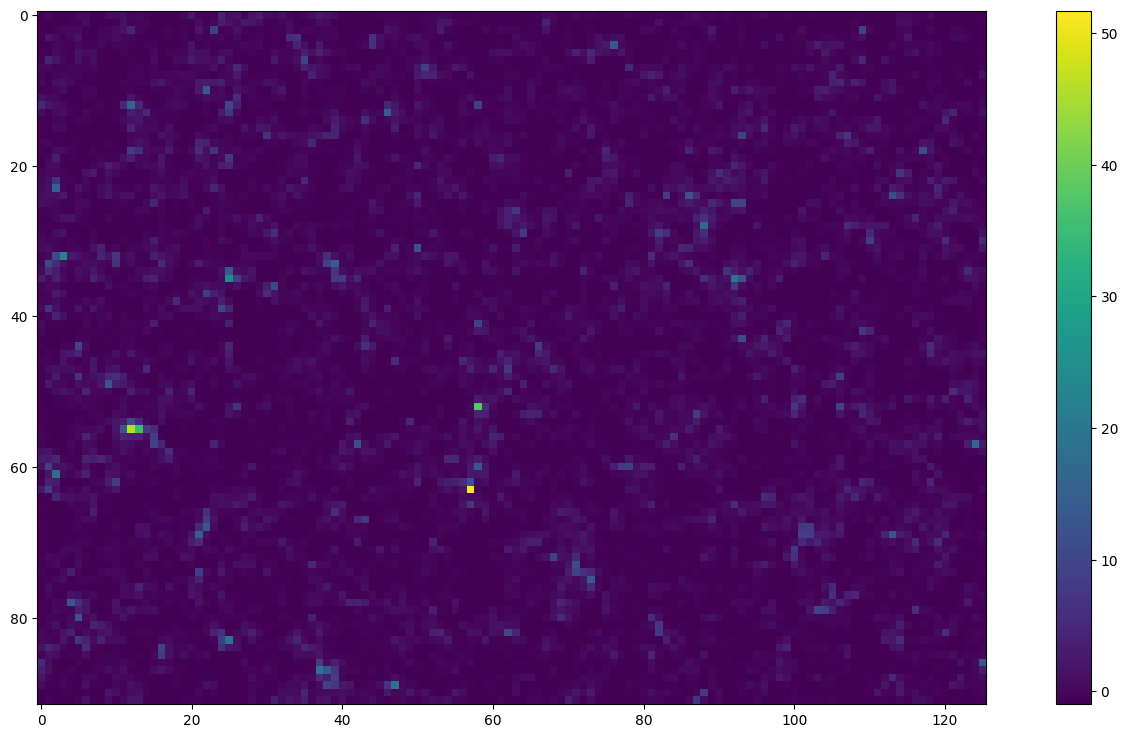

In [10]:
mock = MockSimulation()
# check mock dark matter density field. When invoked, `mock` will generate a realization under the hood
plt.imshow(mock.mock_matter_field[:,:,0])
plt.colorbar()
plt.show()


You wil find that a lognormal dark matter density field is automatically generated. The default setting is to match the box dimensions (not exactly) of the L-band deep-field survey area and Planck18 cosmology:

[ 968.75223308 1345.74828483  395.06093904] [10.52991558 10.68054194  2.10138797] w0waCDM(name="new", H0=67.66 km / (Mpc s), Om0=0.30966, Ode0=0.6888523996875395, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897, w0=-1.0, wa=0.0) 0.4244709677806125


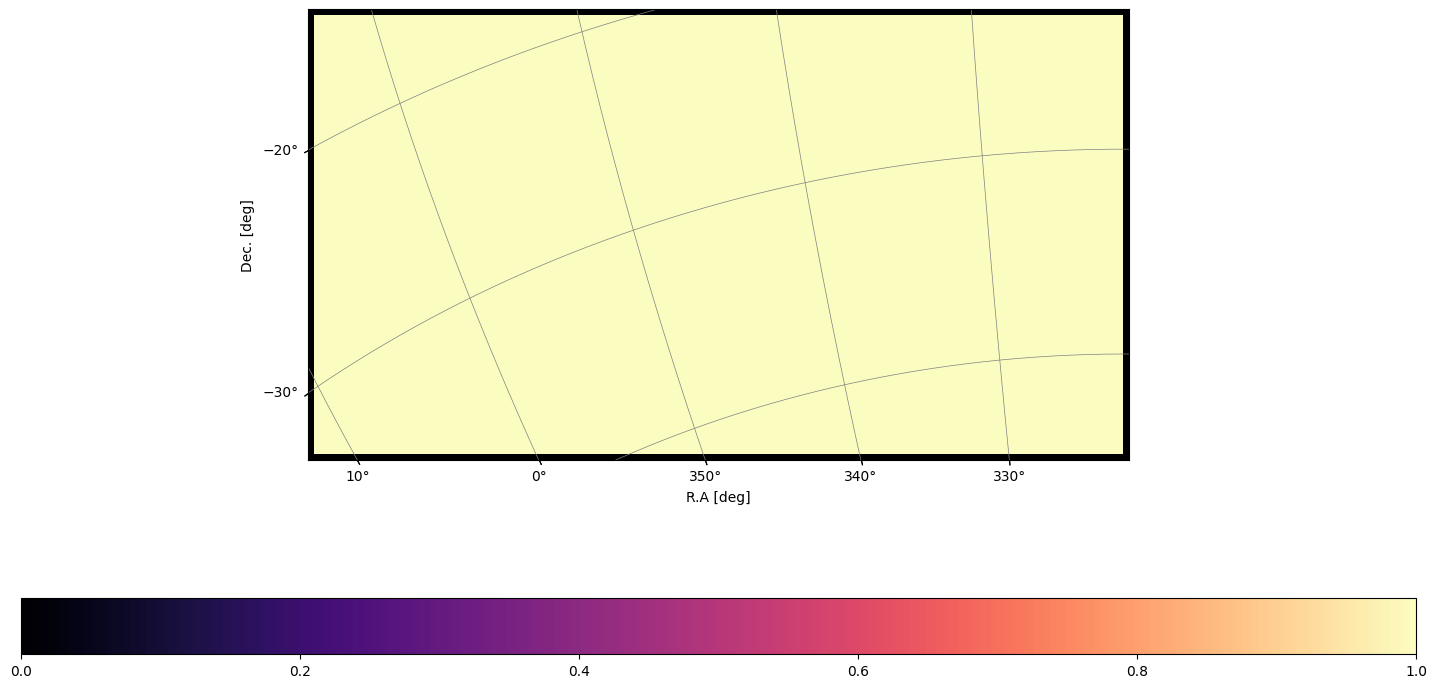

In [11]:
print(mock.box_len, mock.box_resol, mock.cosmo, mock.z)
plot_map(mock.W_HI, mock.wproj)

All the input parameters/models/settings are stored inside the `mock` object, and can be changed whenever you want.
Check the documentation for all the attributes.

In [12]:
# Some selection of the parameters/attributes:
print("Cosmolgy: ", mock.cosmo)
print("Redshift: ", mock.z)
print("HI bias: ", mock.tracer_bias_1)
print("Galaxy bias: ", mock.tracer_bias_2)
print(r"HI density $\Omega_{\rm HI}$: ", mock.omegahi)

Cosmolgy:  w0waCDM(name="new", H0=67.66 km / (Mpc s), Om0=0.30966, Ode0=0.6888523996875395, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897, w0=-1.0, wa=0.0)
Redshift:  0.4244709677806125
HI bias:  1.0
Galaxy bias:  None
HI density $\Omega_{\rm HI}$:  0.0005


For most of the parameters, changing the settings is as simple as `mock.something = new_value`

For example, suppose you want to generate a different cosmology instead, with a cubic box of 500Mpc with 5Mpc resolution:

In [13]:
mock.cosmo = 'Planck15'
print("The box length and the grid number were:", mock.box_len,mock.box_ndim) # was automatically calculated to match the survey area
mock.box_len = np.array([500,500,500])
mock.box_ndim = np.array([100,100,100])
print("Now the box length and the grid number are:", mock.box_len,mock.box_ndim)

The box length and the grid number were: [ 968.75223308 1345.74828483  395.06093904] [ 92 126 188]
Now the box length and the grid number are: [500 500 500] [100 100 100]


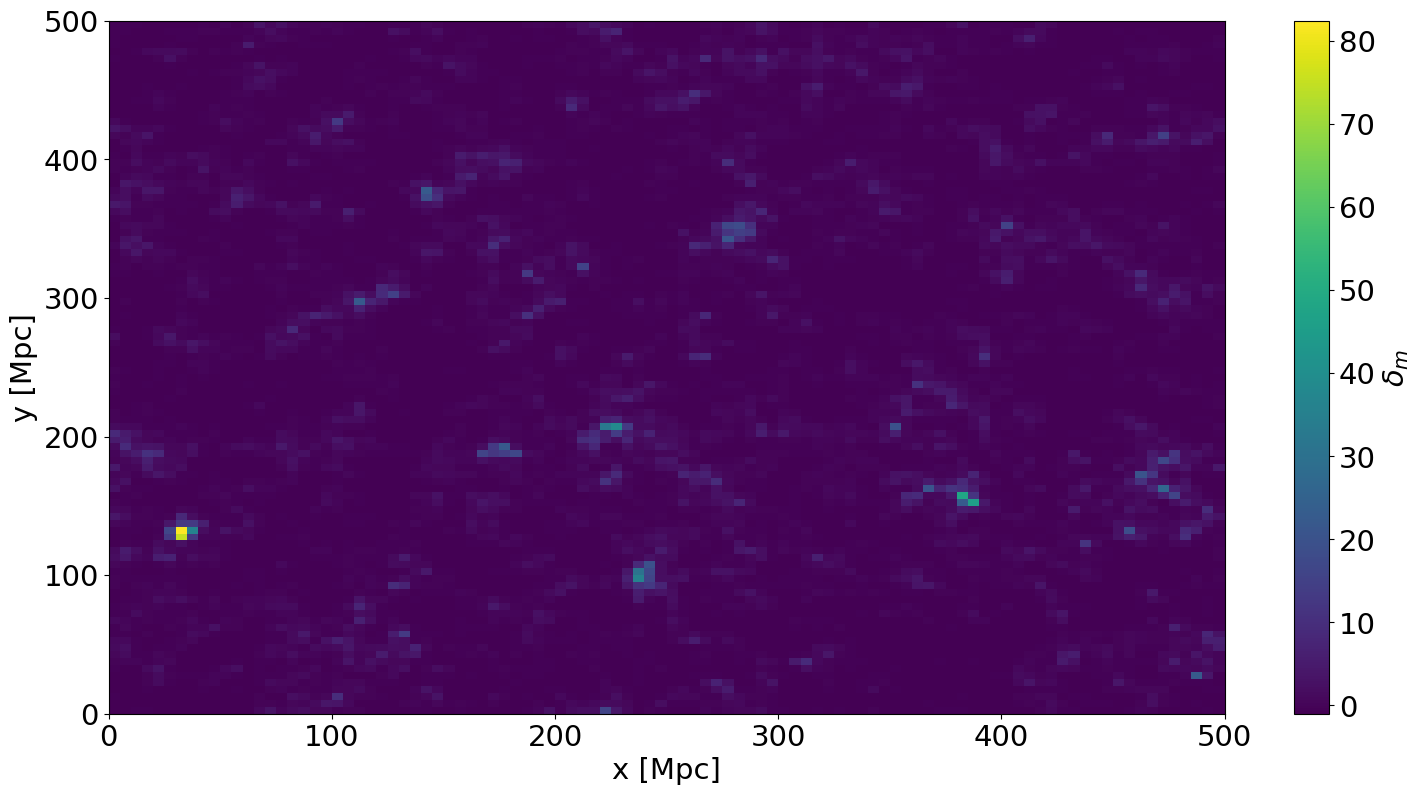

In [18]:
# check one z-slice
plt.rcParams.update({'font.size': 21})
plt.pcolormesh(
    center_to_edges(mock.x_vec[0]),
    center_to_edges(mock.x_vec[1]),
    mock.mock_matter_field[:,:,-2]
)
cbar = plt.colorbar()
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
cbar.set_label(r'$\delta_m$')

A feature of `meer21cm` is that it is designed to be used interactively, allowing extensive testing through changing inputs. It uses a cache structure that **only updates a certain attribute if needed**. For example, if we have changed nothing, invoking `mock.mock_matter_field` is simply printing out an array:

In [19]:
s_t = time.time()
mock.mock_matter_field
print('Time taken to print out the field:', time.time()-s_t)

Time taken to print out the field: 5.602836608886719e-05


Suppose now we change something, for example by using nonlinear instead of linear matter power spectrum to generate the DM field:

In [20]:
print(mock.ps_type) # matter power was `linear`
mock.ps_type = 'nonlinear'

linear


In [21]:
s_t = time.time()
mock.mock_matter_field
print('Time taken to regenerate the field:', time.time()-s_t)

Note: redshifts have been re-sorted (earliest first)
Time taken to regenerate the field: 1.5716419219970703


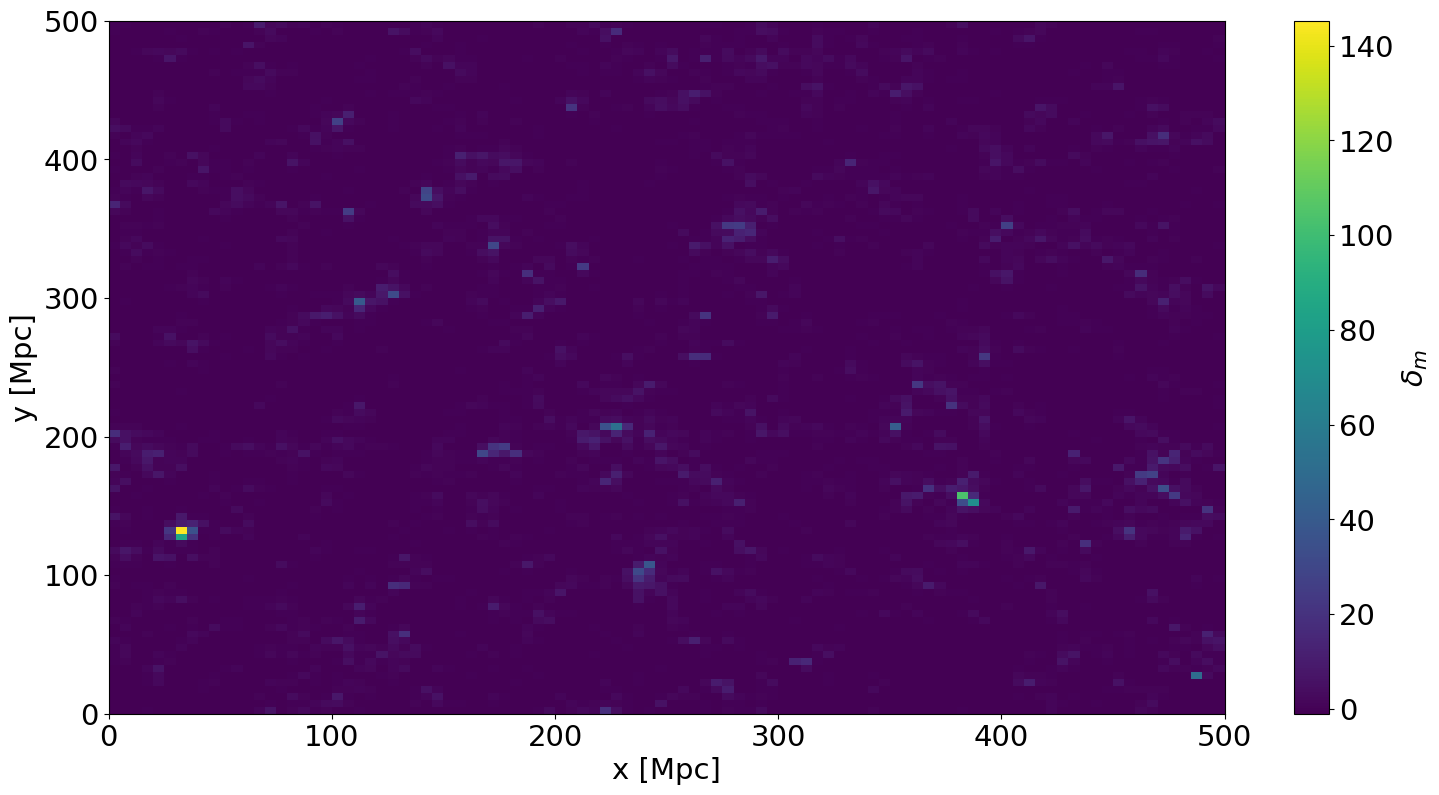

In [22]:
# check one z-slice
plt.rcParams.update({'font.size': 21})
plt.pcolormesh(
    center_to_edges(mock.x_vec[0]),
    center_to_edges(mock.x_vec[1]),
    mock.mock_matter_field[:,:,-2]
)
cbar = plt.colorbar()
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
cbar.set_label(r'$\delta_m$')

Note two things above: First, the underlying seed stays the same, so the distribution is the same. Second, the colour scale changed, with more enhanced peak due to nonlinear clustering.

On the other hand, changing unrelated quantities does not affect the cache:

In [23]:
mock.tracer_bias_1 = 1.5 # setting the HI bias

s_t = time.time()
mock.mock_matter_field
print('Time taken to print out the DM field:', time.time()-s_t)

Time taken to print out the DM field: 3.790855407714844e-05


In `meer21cm`, we focus on the HI simulation and power spectrum analysis, with also support of generating a cross-correlating galaxy catalogue.
While this can be arbitrary, the package is written in a way with the default of `1` being HI and `2` being galaxy. That means, we can generate an HI and a galaxy overdensity field: 

In [29]:
mock.mean_amp_1 = 'average_hi_temp' # tell tracer 1 to use temperature unit
mock.omega_hi = 6e-4 # setting the overall HI density
mock.tracer_bias_1 = 1.5 # HI bias
mock.tracer_bias_2 = 1.9 # galaxy bias
mock.num_discrete_source = 10000 # number of mock galaxies
mock.target_relative_to_num_g = 1.0 # >1 will create buffer for mock galaxies outside the survey area, not relevant here for cubic box

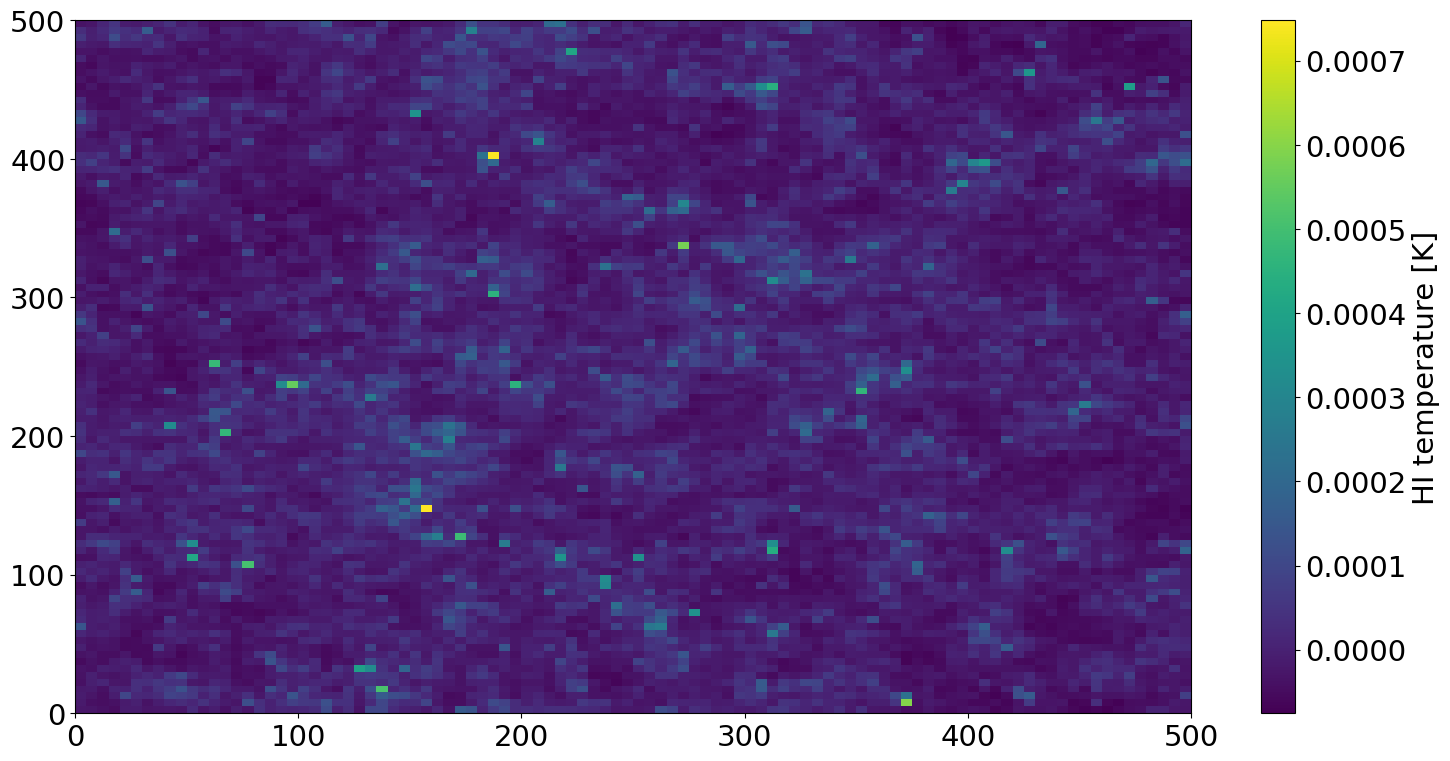

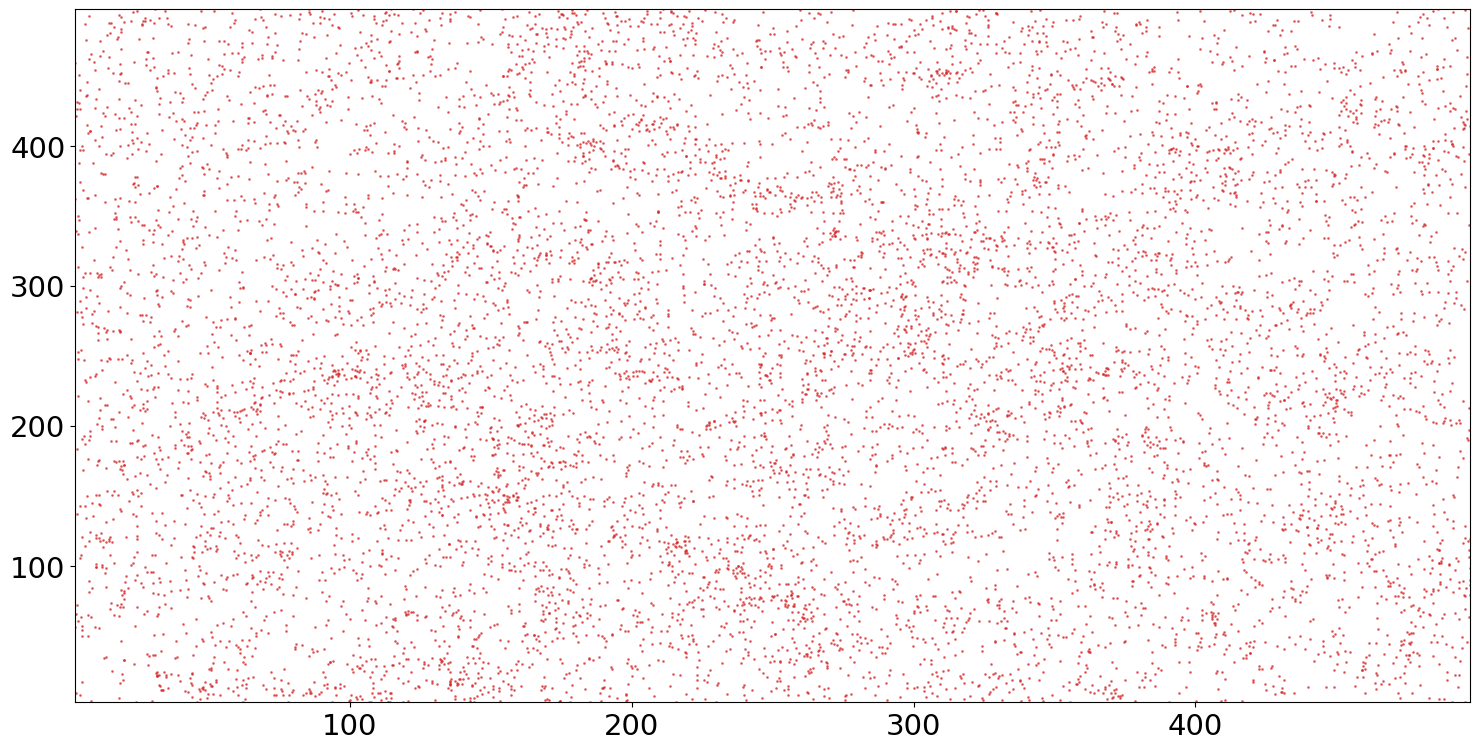

In [30]:

plt.pcolormesh(
    center_to_edges(mock.x_vec[0]),
    center_to_edges(mock.x_vec[1]),
    mock.mock_tracer_field_1.mean(-1).T,
    #cmap='magma'
)
cbar = plt.colorbar()
cbar.set_label('HI temperature [K]')
plt.figure()
plt.xlim(mock.x_vec[0].min(),mock.x_vec[0].max())
plt.ylim(mock.x_vec[1].min(),mock.x_vec[1].max())
plt.scatter(
    mock.mock_tracer_position_in_box[:,0],
    mock.mock_tracer_position_in_box[:,1],
    color='C3',
    s=1,
    alpha=0.6,
)


For any field, `meer21cm` offers automatic calculation of the data power spectrum as well as the corresponding model power spectrum based on the input parameters.

It takes into the account of all sorts of effects (weighting, gridding etc).
For this cubic box with uniform weighting it is as easy as just putting the fields into `mock`:

In [33]:
mock.field_1 = mock.mock_tracer_field_1
# galaxy count in each cell
gal_count,_ = np.histogramdd(
    mock.mock_tracer_position_in_box,
    bins=[center_to_edges(mock.x_vec[i]) for i in range(3)],
)
mock.field_2 = gal_count
mock.mean_center_1 = False # the field is already mean centered
mock.mean_center_2 = True # galaxy count is not
mock.unitless_1 = False # HI field is in temperature unit, does not need to 1/\bar{\pho}
mock.unitless_2 = True # galaxy count to overdensity needs 1/\bar{n}

The 3D power spectrum can then be extracted from `mock`:

In [35]:
print(mock.auto_power_3d_1.shape, mock.cross_power_3d.shape, mock.auto_power_3d_2.shape)
print(mock.auto_power_tracer_1_model.shape, mock.cross_power_tracer_model.shape, mock.auto_power_tracer_2_model.shape)


(100, 100, 100) (100, 100, 100) (100, 100, 100)
(100, 100, 100) (100, 100, 100) (100, 100, 100)


The corresponding k-mode can be read:

In [38]:
print(mock.k_vec[0].shape, mock.k_vec[1].shape, mock.k_vec[2].shape) # each k_x,k_y,k_z
print(mock.k_mode.shape) # |k|
print(mock.k_para.shape, mock.k_perp.shape) # k_para (z), k_perp ((x^2+y^2)^0.5)

(100,) (100,) (100,)
(100, 100, 100)
(100,) (100, 100)


You can then tell `mock` what k-bins you want and bin the 3D power into 1D or cylindrical:

In [42]:
mock.k1dbins = np.linspace(0,1,11)
mock.kperpbins = np.linspace(0,0.9,10)
mock.kparabins = np.linspace(0,0.6,7)

In [62]:
power_field = []
for power_3d in [mock.auto_power_3d_1,mock.cross_power_3d,mock.auto_power_3d_2]:
    power_i,keff,_ = mock.get_1d_power(power_3d)
    power_field.append(power_i)
power_field = np.array(power_field)
power_model = []
for power_3d in [mock.auto_power_tracer_1_model,mock.cross_power_tracer_model,mock.auto_power_tracer_2_model]:
    power_i,keff,_ = mock.get_1d_power(power_3d)
    power_model.append(power_i)
power_model = np.array(power_model)

In [63]:
# galaxy power spectrum has shot noise:
shot_noise = np.prod(mock.box_len)/mock.num_discrete_source

In [64]:
power_field[2] -= shot_noise

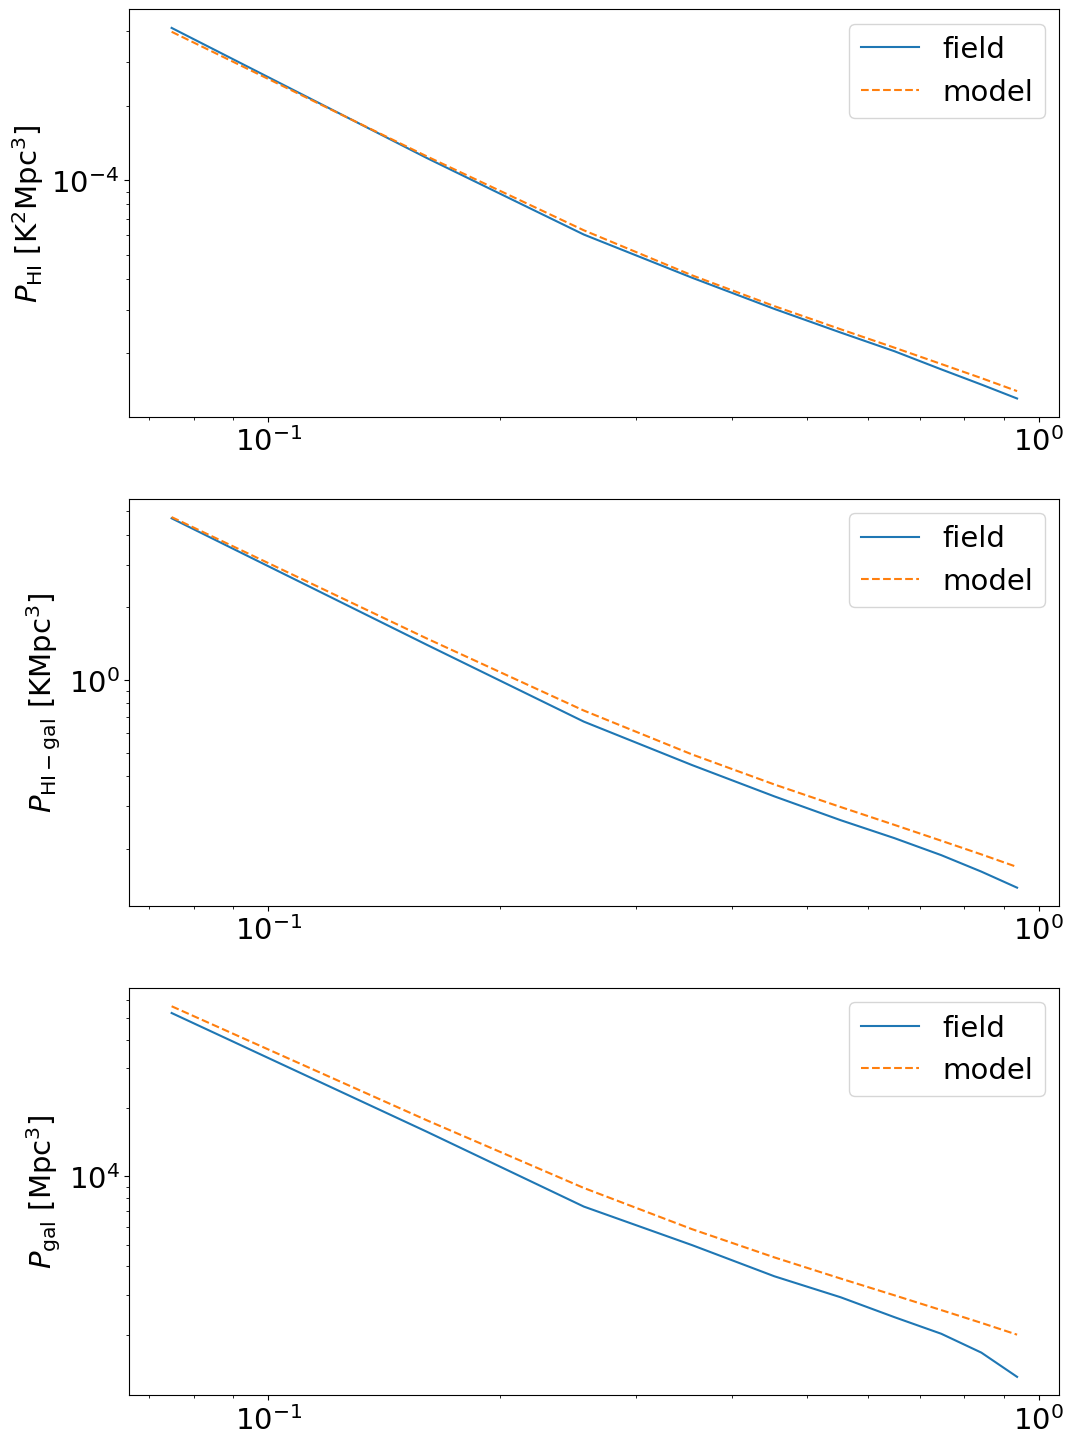

In [65]:
ylabelarr = ['HI','HI-gal','gal']
unitarr = [r'$\rm K^2 Mpc^3$', r'$\rm K Mpc^3$', r'$\rm Mpc^3$']
fig,axes = plt.subplots(3,1,figsize=(12,18))
for i in range(3):
    axes[i].plot(keff,power_field[i],label='field')
    axes[i].plot(keff,power_model[i],label='model',ls='--')
    axes[i].set_ylabel(r'$P_{\rm '+ylabelarr[i]+'}$ [' + unitarr[i] + ']')
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].legend()

An example of visualising the cylindrical power spectrum:

In [69]:
powercy_hi_data,_ = mock.get_cy_power(mock.auto_power_3d_1)
powercy_hi_model,_ = mock.get_cy_power(mock.auto_power_tracer_1_model)


Text(0.5, 0, '$k_\\perp$ [Mpc$^{-1}$]')

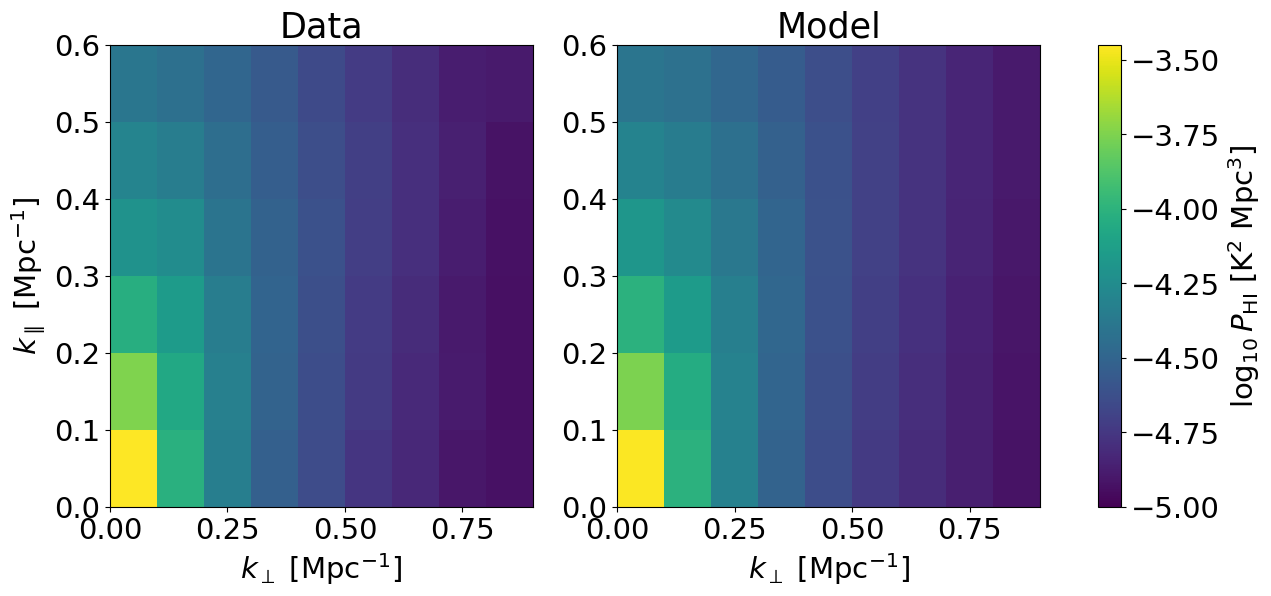

In [77]:
fig,axes = plt.subplots(1,2,figsize=(15,6))
axes[0].pcolormesh(
    mock.kperpbins,
    mock.kparabins,
    np.log10(powercy_hi_data).T,
    vmin=-5,
    vmax=-3.45,
)
im = axes[1].pcolormesh(
    mock.kperpbins,
    mock.kparabins,
    np.log10(powercy_hi_model).T,
    vmin=-5,
    vmax=-3.45,
)
cbar = plt.colorbar(im,ax=axes.ravel())
cbar.set_label(r'$\log_{10} P_{\rm HI}$ [K$^2$ Mpc$^3$]')
axes[0].set_title('Data')
axes[1].set_title('Model')
axes[0].set_xlabel(r'$k_\perp$ [Mpc$^{-1}$]')
axes[0].set_ylabel(r'$k_\parallel$ [Mpc$^{-1}$]')
axes[1].set_xlabel(r'$k_\perp$ [Mpc$^{-1}$]')